# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
# add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
# add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
import time
import datetime
import pandas as pd

seed = 77

data_file = 'untrunc_data_cleaned_url.csv'

raw_data = pd.read_table(data_file, sep=',', index_col=0)
raw_data = raw_data.dropna()

raw_data.info()

print(f'raw_data: {raw_data.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58875 entries, 0 to 58911
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58875 non-null  float64
 1   has_www                                 58875 non-null  float64
 2   has_iframe                              58875 non-null  float64
 3   int                                     58875 non-null  float64
 4   org                                     58875 non-null  float64
 5   gov                                     58875 non-null  float64
 6   in                                      58875 non-null  float64
 7   eu                                      58875 non-null  float64
 8   cn                                      58875 non-null  float64
 9   kr                                      58875 non-null  float64
 10  url_depth                               58875 non-null  fl

### Train Test Split

In [3]:
import gc
import multiprocessing

import warnings
warnings.filterwarnings("ignore")


cpu_cnt = multiprocessing.cpu_count()
allocated_cpu = cpu_cnt
print(f"Allocated {allocated_cpu} CPUs")
gc.collect()

Allocated 16 CPUs


0

#### L-BFGS-B

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing


x = raw_data.drop(['label', 'first_appear', 'url'], axis=1)
y = raw_data.label
y = preprocessing.StandardScaler().fit_transform(y.values.reshape(-1, 1))
y = pd.DataFrame(y).iloc[:,0]

n_sample = len(y)
start_time = time.time()


In [5]:
def get_tobit_result(
    i, logger,
    p_censor_left, p_censor_right, C, alpha,
    x, y
):
    idx = resample(y.index, n_samples=len(y), replace=True, stratify=y)
    if i % 100 == 0:
        logger.debug(f'No. {i} - Start')

    tr = TobitRegressor(
        p_censor_left=p_censor_left,
        p_censor_right=p_censor_right,
        C=C,
        alpha=alpha,
    )

    X_train = x.iloc[idx, :]
    y_train = y.iloc[idx]

    tr.fit(X_train, y_train)

    row = pd.DataFrame([tr.intercept_, *tr.coef_, tr.sigma_, tr]).T
    row.columns = ['intercept', *x.columns, 'log(sigma)', 'model']

    if i % 100 == 0:
        logger.debug(f'No. {i} - End')
    return row

In [6]:
from concurrent.futures.thread import ThreadPoolExecutor
import logging


from tobit import *


p_censor_left = -math.inf
p_censor_right = max(y)


performance_matrix = pd.DataFrame(columns=['intercept', *x.columns, 'log(sigma)', 'model'])

idx_train = list()

C=49.8
alpha=1
LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logger = logging.getLogger('Tobit Training')
logger.setLevel(logging.DEBUG)


futures = list()

# with ThreadPoolExecutor(max_workers=4) as executor:
#     for i in range(1000):
#         future = executor.submit(get_tobit_result,
#                                    i, logger,
#                                    p_censor_left, p_censor_right, C, alpha,
#                                    x, y)
        
#         futures.append(future)
#     executor.shutdown(wait=True)
for i in range(1000):
    future = get_tobit_result(i, logger,
                               p_censor_left, p_censor_right, C, alpha,
                               x, y)

    futures.append(future)

for future in futures:
    performance_matrix = performance_matrix.append(future)

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

2021-01-30 01:19:47,975 - DEBUG - No. 0 - Start
2021-01-30 01:20:11,076 - DEBUG - No. 0 - End
2021-01-30 02:06:02,604 - DEBUG - No. 100 - Start
2021-01-30 02:06:22,348 - DEBUG - No. 100 - End
2021-01-30 02:48:43,890 - DEBUG - No. 200 - Start
2021-01-30 02:48:58,825 - DEBUG - No. 200 - End
2021-01-30 03:28:12,172 - DEBUG - No. 300 - Start
2021-01-30 03:28:34,485 - DEBUG - No. 300 - End
2021-01-30 04:07:07,747 - DEBUG - No. 400 - Start
2021-01-30 04:07:34,661 - DEBUG - No. 400 - End
2021-01-30 04:43:14,212 - DEBUG - No. 500 - Start
2021-01-30 04:43:27,108 - DEBUG - No. 500 - End
2021-01-30 05:14:25,854 - DEBUG - No. 600 - Start
2021-01-30 05:14:42,509 - DEBUG - No. 600 - End
2021-01-30 05:46:30,589 - DEBUG - No. 700 - Start
2021-01-30 05:46:42,905 - DEBUG - No. 700 - End
2021-01-30 06:18:17,541 - DEBUG - No. 800 - Start
2021-01-30 06:18:34,621 - DEBUG - No. 800 - End
2021-01-30 06:49:36,183 - DEBUG - No. 900 - Start
2021-01-30 06:49:54,574 - DEBUG - No. 900 - End


--- 03 minutes, 5.88 seconds ---


In [7]:
# import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_distribution(coef_matrix, title):
    # Calculate the order of the mean value for each feature
    fig = plt.figure(figsize=(18, 15))
    coef_median = coef_matrix.apply(lambda x: x.median())
    coef_order = coef_median.sort_values(ascending=False).index.tolist()
    ax = sns.boxplot(data=coef_matrix,
                     order=coef_order,
                     orient="h",)
    plt.axvline(x=0, color='red')
    

    plt.title(title, fontsize=15)


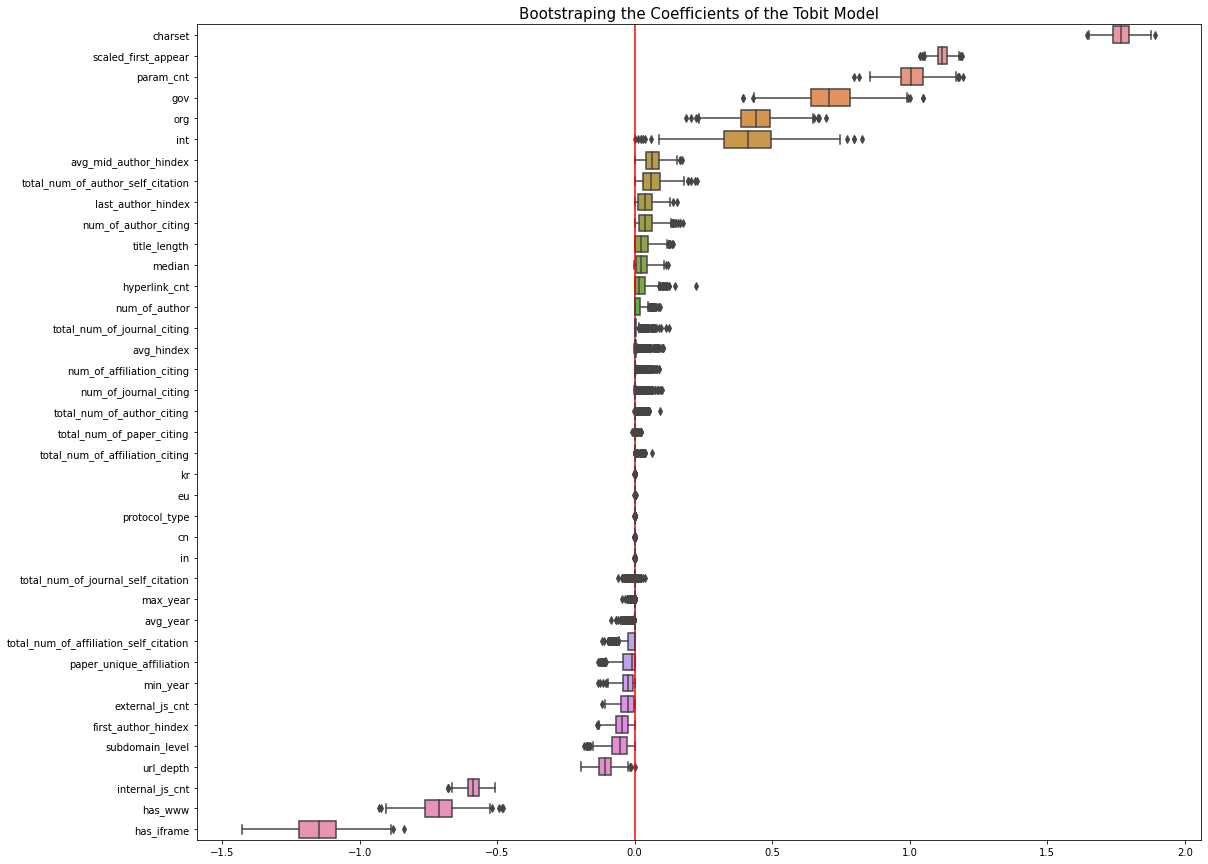

In [13]:
feature_names = [*x.columns, 'log(sigma)']

# Get the model without any penalty term
coef_matrix = performance_matrix.loc[:, feature_names]
plot_feature_distribution(
    coef_matrix, 
    "Bootstraping the Coefficients of the Tobit Model")

In [9]:
from sklearn.metrics import mean_squared_error


def get_pseudo_r2(y_true, y_hat):
    correlation_matrix = np.corrcoef(
        y_true.astype(float), 
        y_hat.astype(float)
    )
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

def predict(feature_names, X, coef):
    X = X.copy()
    X.insert(0, 'intercept', 1.0)
    X = X.loc[:, ['intercept', *feature_names]]
    return X @ coef


def create_pseudo_r2_matrix(x, y):
    def _create_pseudo_r2_matrix(row):
        y_hat = predict(feature_names, x, row.loc[['intercept', *feature_names]])
        return get_pseudo_r2(y, y_hat)

    return _create_pseudo_r2_matrix

def create_mse_matrix(x, y):
    def _create_mse_matrix(row):
        y_hat = predict(feature_names, x, row.loc[['intercept', *feature_names]])
        return math.sqrt(mean_squared_error(y, y_hat))

    return _create_mse_matrix


feature_names = x.columns
coef = performance_matrix[['intercept', *feature_names]].iloc[0,:]


r2 = get_pseudo_r2(y, predict(feature_names, x, coef))

print(f'Pseudo R square: %.2f%%' % (r2 * 100))


# Create {prediction}/{pseudo r2}/{residual}
performance_matrix.loc[:, 'pseudo_r2'] = performance_matrix.apply(create_pseudo_r2_matrix(x, y), axis=1)
performance_matrix.loc[:, 'rmse'] = performance_matrix.apply(create_mse_matrix(x, y), axis=1)
performance_matrix.loc[:, 'loglik'] = performance_matrix.model.apply(lambda model: model.score(x, y))


Pseudo R square: 12.94%


Text(0.5, 0.93, 'The Distribution of the model Performace')

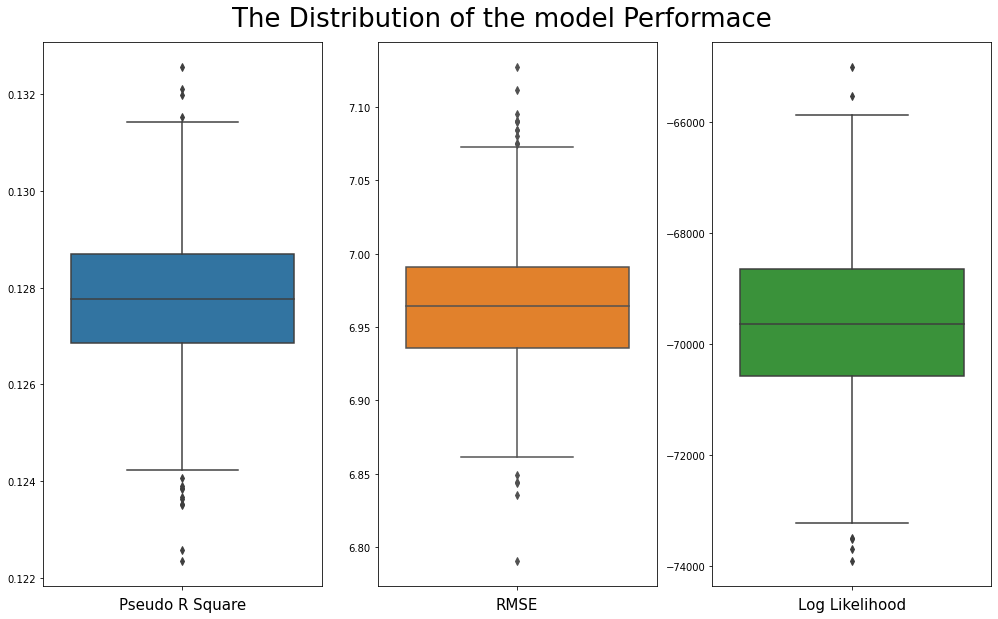

In [10]:
import itertools

pseudo_r2 = performance_matrix.pseudo_r2
rmse = performance_matrix.rmse
loglik = performance_matrix.loglik


palette = itertools.cycle(sns.color_palette())
f, ax = plt.subplots(1, 3, figsize=(17,10))

sns.boxplot(y=pseudo_r2, color=next(palette), ax=ax[0])
sns.boxplot(y=rmse, color=next(palette), ax=ax[1])
sns.boxplot(y=loglik, color=next(palette), ax=ax[2])

ax[0].set_xlabel('Pseudo R Square', fontsize=15)
ax[1].set_xlabel('RMSE', fontsize=15)
ax[2].set_xlabel('Log Likelihood', fontsize=15)
ax[0].set_ylabel('', fontsize=15)
ax[1].set_ylabel('', fontsize=15)
ax[2].set_ylabel('', fontsize=15)

plt.suptitle("The Distribution of the model Performace", y=.93, size=26)
